## CSGO Assignment 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import scipy.stats
from collections import Counter

conn = psycopg2.connect(database="test", user="postgres", password="0000", host="localhost", port="5432")

### Data preprocessing

In [2]:
# Import data
df = pd.read_sql("SELECT * FROM csgo.profiles", conn)
df_mapstats = pd.read_sql("SELECT * FROM csgo.maps_stats", conn)
df_map = pd.read_sql("SELECT * FROM csgo.maps", conn)
df_rank = pd.read_sql("SELECT * FROM csgo.ranks", conn)
df_team_maps = pd.read_sql("SELECT * FROM csgo.team_best_maps", conn)
df_weaponstats = pd.read_sql("SELECT * FROM csgo.weapons_stats", conn)

df_profilerole = pd.read_sql("SELECT * FROM games.profiles_roles", conn)
df_role = pd.read_sql("SELECT * FROM games.roles", conn)


# Drop values that shouldn't be NaN for normal players
df = df.dropna(subset=['total_kills','total_deaths','total_time_played','total_rounds_played',
                                             'total_shots_fired'])
# Fill NaN
df.fillna(0, inplace=True)

# Add Kill Death Ratio
df['kill_death_ratio'] = df['total_kills'].div(df['total_deaths'] ,axis='index')
df['headshot_ratio'] = df['total_kills_headshot'].div(df['total_kills'] ,axis='index')
df['accuracy'] = df['total_shots_hit'].div(df['total_shots_fired'] ,axis='index')
df['win_rate'] = df['total_wins'].div(df['total_rounds_played'] ,axis='index')
df['mvp_percentage'] = df['total_mvps'].div(df['total_rounds_played'] ,axis='index')
#df['kills_per_round'] = df['total_kills'].div(df['total_rounds_played'] ,axis='index')
#df['death_per_round'] = df['total_deaths'].div(df['total_rounds_played'] ,axis='index')

# Exclude unreasonable data
df = df[(df['total_time_played'] != 0) & (df['total_shots_fired'] != 0) & (df['total_deaths'] != 0) & (df['total_kills'] != 0) &
        (df['total_shots_fired']>df['total_kills']) & (df['total_kills_headshot']<df['total_kills']) &  
        (df['total_time_played'] <= 1963*12*60*60) & (df['total_mvps']<df['total_rounds_played']) & 
        (df['total_deaths']<1963*12*30) & (df['total_kills']<df['total_rounds_played']*9) & (df['kill_death_ratio']<=15) & 
        (df['win_rate']<1) & (df['accuracy']<1)]

df_test = df

# Game released in 21Aug2013, the latest updated profile in data is 5Jan2018, game hours played should not exceed 1963 days
# Total MVP should be less than total rounds played
# Max game round per hour is 30, total death should not exceed 1963days*12hour*30rounds
# Exclude more than 9 kills per round
# Exclude Kill Death ratio exceed 15

df = df.drop(['nickname','steam_id','about','updated_at','compensation',
              'total_kills_headshot','total_kills','total_deaths','total_wins','total_rounds_played',
              'total_shots_fired','total_shots_hit'],axis=1)

df = df.set_index('user_id')

In [3]:
df.head()

,total_time_played,total_mvps,rank_id,goal_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
user_id,,,,,,,,,
145,1216.0,0.0,1,1,0.111111,0.000000,0.727273,0.125000,0.000000
216,4726211.0,3122.0,11,1,0.793251,0.308351,0.176158,0.507693,0.069118
154,9229.0,0.0,1,3,0.901163,0.274194,0.174500,0.549020,0.000000
187,10472.0,9.0,1,1,0.745455,0.292683,0.107234,0.550000,0.112500
176,2510854.0,2743.0,8,1,0.778298,0.299179,0.217408,0.484754,0.152347


In [4]:
df.describe()

,total_time_played,total_mvps,rank_id,goal_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,7.456900e+04,74569.000000,74569.000000,74569.000000,74569.000000,74569.000000,74569.000000,74569.000000,74569.000000
mean,2.015226e+06,3527.986160,10.852875,2.334952,1.074401,0.372167,0.185858,0.508784,0.129591
std,1.956982e+06,4310.848595,4.736885,0.771197,0.347274,0.092255,0.030042,0.056574,0.044203
min,8.700000e+01,0.000000,1.000000,1.000000,0.000675,0.000000,0.029786,0.000000,0.000000
25%,6.806610e+05,1084.000000,7.000000,2.000000,0.912453,0.310152,0.167507,0.488532,0.102434
50%,1.513194e+06,2517.000000,11.000000,3.000000,1.035350,0.363775,0.184454,0.502232,0.122866
75%,2.800341e+06,4836.000000,15.000000,3.000000,1.174255,0.425694,0.202457,0.517496,0.149133
max,7.332304e+07,681118.000000,18.000000,3.000000,13.111460,0.998323,0.997726,0.999708,0.983967


## Correlation

In [5]:
df_corr = df_test[['rank_id','total_time_played','total_mvps','kill_death_ratio','headshot_ratio','accuracy',
               'win_rate','mvp_percentage','total_kills_headshot','total_kills','total_deaths','total_wins',
               'total_rounds_played', 'total_shots_fired','total_shots_hit']].copy()
corr = df_corr.corr()
df_corr.corr()

,rank_id,total_time_played,total_mvps,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage,total_kills_headshot,total_kills,total_deaths,total_wins,total_rounds_played,total_shots_fired,total_shots_hit
rank_id,1.000000,0.503628,0.429757,0.186075,0.465744,0.165440,0.147835,0.171853,0.473510,0.497598,0.474077,0.491430,0.066824,0.042500,0.014678
total_time_played,0.503628,1.000000,0.648009,0.008187,0.254067,0.017225,-0.001590,-0.021629,0.767316,0.827430,0.843160,0.806926,0.102280,0.071072,0.021901
total_mvps,0.429757,0.648009,1.000000,0.129684,0.248745,0.108116,0.025623,0.251762,0.700260,0.720608,0.634015,0.697978,0.095119,0.080508,0.052587
kill_death_ratio,0.186075,0.008187,0.129684,1.000000,0.167003,0.444636,0.478340,0.453975,0.169277,0.149944,-0.047974,0.065172,0.069406,0.012147,0.013112
headshot_ratio,0.465744,0.254067,0.248745,0.167003,1.000000,0.104303,0.017652,0.234594,0.442644,0.261809,0.236148,0.245825,0.045126,0.039233,0.023004
accuracy,0.165440,0.017225,0.108116,0.444636,0.104303,1.000000,0.196469,0.339498,0.132917,0.130830,0.045788,0.041068,0.071819,0.074798,0.079859
win_rate,0.147835,-0.001590,0.025623,0.478340,0.017652,0.196469,1.000000,0.309358,0.053287,0.070707,-0.013016,0.067008,-0.034081,-0.009011,-0.009252
mvp_percentage,0.171853,-0.021629,0.251762,0.453975,0.234594,0.339498,0.309358,1.000000,0.096401,0.082487,0.004412,0.033786,-0.008054,0.001157,0.001925
total_kills_headshot,0.473510,0.767316,0.700260,0.169277,0.442644,0.132917,0.053287,0.096401,1.000000,0.922745,0.826709,0.727074,0.179543,0.085550,0.040651
total_kills,0.497598,0.827430,0.720608,0.149944,0.261809,0.130830,0.070707,0.082487,0.922745,1.000000,0.927157,0.782094,0.158031,0.079543,0.031612


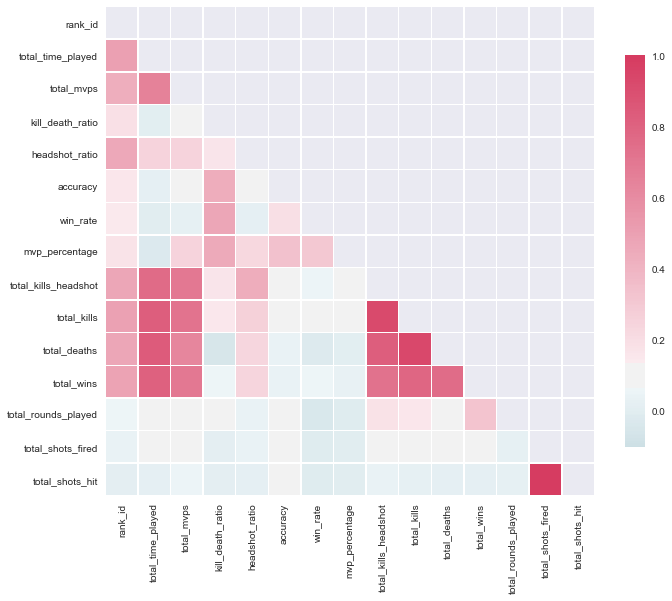

In [6]:
sns.set()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.1 ,vmax=1, center=0.1,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

#plt.savefig('corrall.png')
plt.show()

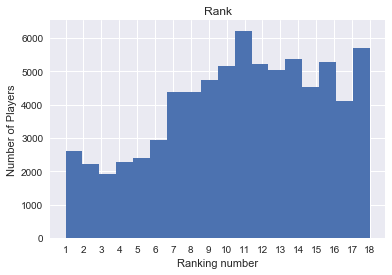

In [7]:
plt.hist(df['rank_id'],bins=18)
plt.title('Rank')
plt.xlabel('Ranking number')
plt.ylabel('Number of Players')
plt.xticks(np.arange(min(df['rank_id']), max(df['rank_id'])+1, 1.0))
plt.show()

In [8]:
df[df['rank_id']==18].shape

(5713, 9)

## Kmeans

In [9]:
df_kmeans = df.drop(['rank_id','total_time_played','total_mvps','goal_id'],axis=1)
df_kmeans = df_kmeans.reset_index(drop=True)
df_target = df[['rank_id']].reset_index(drop=True)
df_kmeans.head()

,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
0,0.111111,0.000000,0.727273,0.125000,0.000000
1,0.793251,0.308351,0.176158,0.507693,0.069118
2,0.901163,0.274194,0.174500,0.549020,0.000000
3,0.745455,0.292683,0.107234,0.550000,0.112500
4,0.778298,0.299179,0.217408,0.484754,0.152347


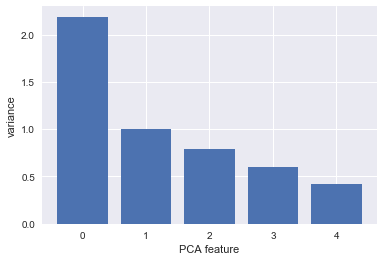

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)


pipeline.fit(df_kmeans.values)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [11]:
pca = PCA(n_components=2)
pca.fit(df_kmeans.values)

pca_features = pca.transform(df_kmeans.values)
print(pca_features.shape)

(74569, 2)


In [12]:
pca_features_rank = pd.DataFrame(data = pca_features, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([pca_features_rank, df_target], axis = 1)

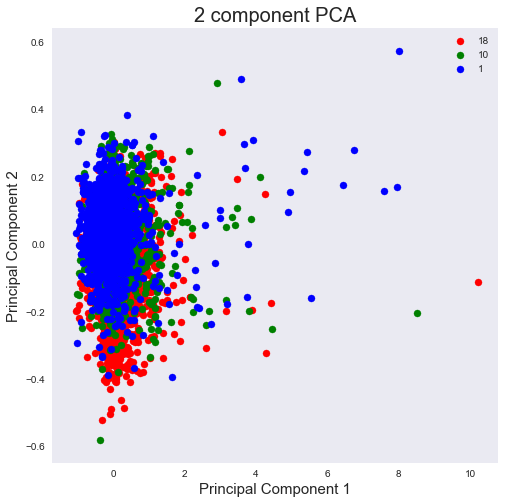

In [13]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [18,10,1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['rank_id'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

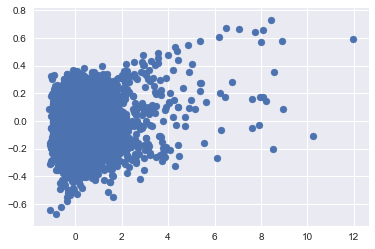

In [14]:
plt.scatter(pca_features[:,0], pca_features[:,1])
plt.show()

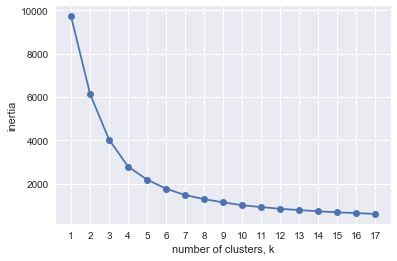

In [15]:
from sklearn.cluster import KMeans
ks = range(1, 18)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(pca_features)  
    inertias.append(model.inertia_)  

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [16]:
finalDf_all = pd.concat([finalDf, df_kmeans], axis = 1)
finalDf_all.head()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
0,-0.991493,0.306517,1,0.111111,0.000000,0.727273,0.125000,0.000000
1,-0.286288,0.055184,11,0.793251,0.308351,0.176158,0.507693,0.069118
2,-0.181572,0.102921,1,0.901163,0.274194,0.174500,0.549020,0.000000
3,-0.331279,0.067707,1,0.745455,0.292683,0.107234,0.550000,0.112500
4,-0.296921,0.054332,8,0.778298,0.299179,0.217408,0.484754,0.152347


In [17]:
finalDf_all[finalDf_all['principal component 1']>2].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,3.534663,0.070942,9.960526,4.609267,0.467233,0.276576,0.612318,0.255655
std,1.761147,0.250977,5.168800,1.771248,0.237195,0.100428,0.154861,0.160367
min,2.008029,-0.421288,1.000000,3.082864,0.000000,0.119675,0.014181,0.000024
25%,2.295060,-0.150712,7.000000,3.365527,0.268141,0.213401,0.513918,0.138205
50%,2.955050,0.062178,10.000000,4.017383,0.475910,0.261595,0.588890,0.216441
75%,3.916372,0.249123,14.000000,4.988095,0.657912,0.302408,0.714504,0.351981
max,11.971170,0.726932,18.000000,13.111460,0.998323,0.997726,0.999708,0.785714


In [18]:
finalDf_all[finalDf_all['principal component 1']<2].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000
mean,-0.010841,-0.000218,10.855611,1.063560,0.371875,0.185580,0.508467,0.129205
std,0.273241,0.090284,4.735279,0.270090,0.091310,0.029140,0.055716,0.042808
min,-1.110139,-0.671207,1.000000,0.000675,0.000000,0.029786,0.000000,0.000000
25%,-0.164139,-0.052894,7.000000,0.911984,0.310172,0.167474,0.488500,0.102417
50%,-0.040255,0.007008,11.000000,1.034671,0.363643,0.184365,0.502182,0.122796
75%,0.099829,0.059013,15.000000,1.172674,0.425414,0.202294,0.517383,0.148943
max,1.995246,0.397141,18.000000,3.078237,0.991240,0.994746,0.998289,0.983967


In [19]:
finalDf_all[finalDf_all['principal component 1']>2].head(20)

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
147,3.204868,-0.245846,17,4.274295,0.774758,0.395702,0.507441,0.119788
291,2.307776,-0.041131,15,3.386763,0.523331,0.232503,0.509884,0.162224
558,8.009113,0.574164,1,9.100000,0.175824,0.446753,0.780488,0.390244
788,3.168994,0.097658,15,4.237753,0.416829,0.231135,0.644212,0.340442
1243,4.237691,0.149944,18,5.306801,0.414834,0.434938,0.639820,0.330626
1245,2.064281,0.066256,10,3.136388,0.400223,0.221875,0.592549,0.246084
1343,2.074925,0.301529,6,3.176664,0.173402,0.198180,0.484018,0.090346
1825,2.311595,-0.125840,1,3.375000,0.592593,0.170431,0.545455,0.363636
1861,3.885337,-0.210904,13,4.965698,0.776581,0.310281,0.493270,0.086325
2180,2.129467,0.176904,10,3.202832,0.317165,0.247296,0.752846,0.066667


In [20]:
finalDf_all[finalDf_all['principal component 2']<-0.3].head()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
1118,0.075998,-0.301884,17,1.135792,0.677830,0.174477,0.509008,0.145831
1341,1.134570,-0.327391,13,2.182927,0.754190,0.258778,0.611111,0.206349
1887,-0.489342,-0.427733,5,0.567601,0.781406,0.105202,0.503024,0.099130
2031,-0.173420,-0.379699,13,0.886275,0.747142,0.147071,0.492177,0.103529
2063,0.145486,-0.304530,17,1.195177,0.675441,0.208172,0.546898,0.253763


In [21]:
finalDf_all[finalDf_all['principal component 2']<-0.3].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000
mean,0.140266,-0.356873,14.693811,1.197180,0.734710,0.204070,0.497823,0.151610
std,0.637189,0.058955,4.336808,0.634901,0.064876,0.091991,0.099413,0.064140
min,-1.077289,-0.671207,1.000000,0.006268,0.596836,0.092424,0.002437,0.000000
25%,-0.194261,-0.376764,13.000000,0.864324,0.688720,0.164284,0.490809,0.114218
50%,0.023569,-0.337962,16.000000,1.079983,0.718555,0.184901,0.504419,0.135833
75%,0.264999,-0.316738,18.000000,1.327548,0.761985,0.211888,0.523925,0.172735
max,4.283604,-0.300132,18.000000,5.359184,0.991240,0.994746,0.964472,0.461705


In [22]:
finalDf_all[finalDf_all['principal component 2']>-0.3].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000
mean,-0.000580,0.001475,10.836996,1.073894,0.370668,0.185783,0.508830,0.129500
std,0.347769,0.088459,4.732029,0.345505,0.089349,0.029496,0.056326,0.044080
min,-1.110139,-0.299388,1.000000,0.000675,0.000000,0.029786,0.000000,0.000000
25%,-0.163558,-0.052137,7.000000,0.912649,0.309889,0.167525,0.488527,0.102398
50%,-0.039598,0.007452,11.000000,1.035278,0.363340,0.184450,0.502221,0.122828
75%,0.100996,0.059424,15.000000,1.173898,0.424757,0.202435,0.517468,0.149065
max,11.971170,0.726932,18.000000,13.111460,0.998323,0.997726,0.999708,0.983967


In [23]:
from sklearn.cluster import KMeans
num_clusters = 3
model = KMeans(n_clusters=num_clusters)
model.fit(pca_features)  

clusters = model.labels_

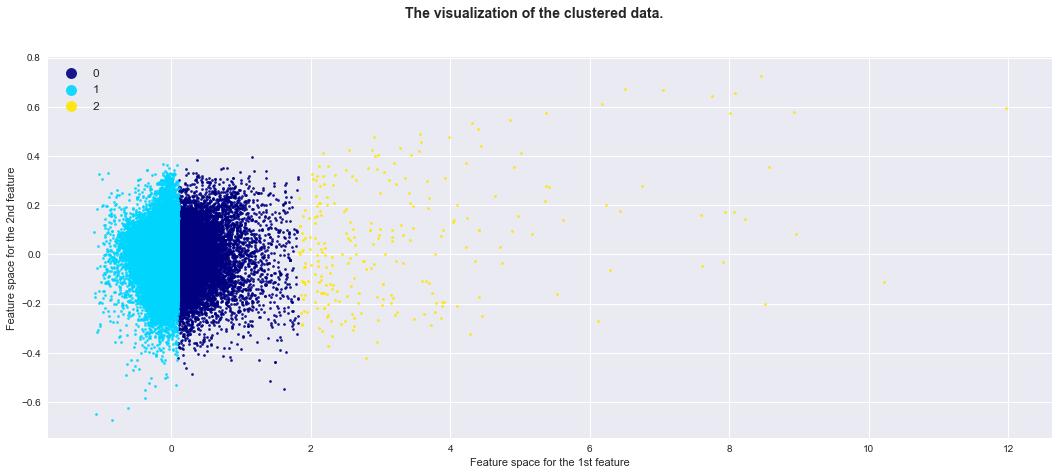

In [24]:
X = pca_features

df_plot = pd.DataFrame({'x': X[:,0], 'y': X[:,1], 'cluster': clusters})

fig, ax = plt.subplots()
fig.set_size_inches(18, 7)

cmap = plt.cm.get_cmap('jet')
for i, cluster in df_plot.groupby('cluster'):
    _ = ax.scatter(cluster['x'], cluster['y'], c=cmap(i/num_clusters), label=i, marker='.', s=30, lw=0, alpha=0.9, edgecolor='k')


ax.set_title("")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
ax.legend(fontsize = 12, markerscale = 4, loc = "best")

plt.suptitle("The visualization of the clustered data.", fontsize=14, fontweight='bold')

plt.show()

In [25]:
from sklearn.cluster import KMeans
num_clusters = 6
model = KMeans(n_clusters=num_clusters)
model.fit(pca_features)  

clusters = model.labels_

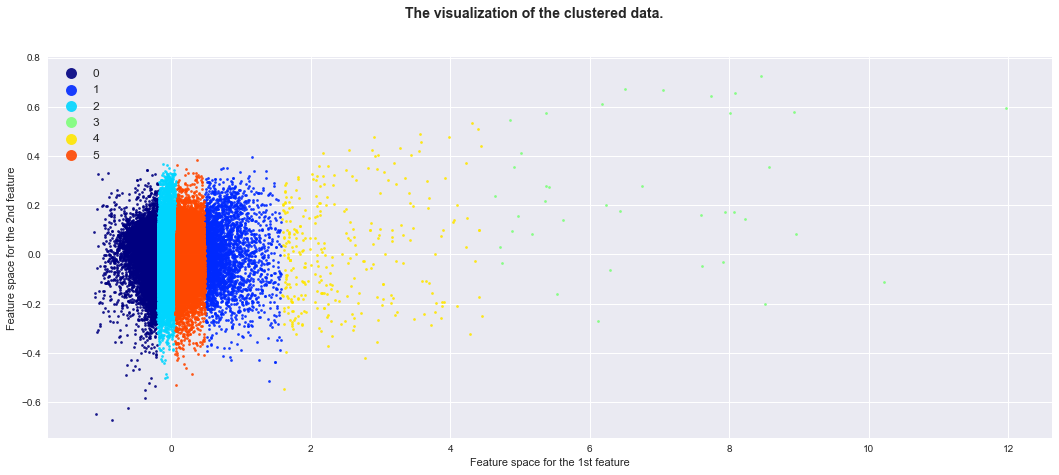

In [26]:
X = pca_features

df_plot = pd.DataFrame({'x': X[:,0], 'y': X[:,1], 'cluster': clusters})

fig, ax = plt.subplots()
fig.set_size_inches(18, 7)

cmap = plt.cm.get_cmap('jet')
for i, cluster in df_plot.groupby('cluster'):
    _ = ax.scatter(cluster['x'], cluster['y'], c=cmap(i/num_clusters), label=i, marker='.', s=30, lw=0, alpha=0.9, edgecolor='k')


ax.set_title("")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
ax.legend(fontsize = 12, markerscale = 4, loc = "best")

plt.suptitle("The visualization of the clustered data.", fontsize=14, fontweight='bold')

plt.show()

In [27]:
df_label = pd.DataFrame(data = clusters, columns = ['label'])
finalDf_all_label = pd.concat([finalDf_all, df_label], axis = 1)

In [28]:
finalDf_all_label[finalDf_all_label['win_rate']>0.6]['label'].value_counts()

5    1275
1    1120
2     350
4     152
0      85
3      18
Name: label, dtype: int64

In [29]:
finalDf_all_label[finalDf_all_label['win_rate']>0.5]['label'].value_counts()

2    18960
5    15905
1     2956
0     2482
4      278
3       27
Name: label, dtype: int64

In [30]:
finalDf_all_label[finalDf_all_label['mvp_percentage']>0.3]['label'].value_counts()

1    177
5    114
4     85
2     48
3     15
0      8
Name: label, dtype: int64

In [31]:
finalDf_all_label[finalDf_all_label['kill_death_ratio']>=3]['label'].value_counts()

4    194
3     39
Name: label, dtype: int64

In [32]:
finalDf_all_label[finalDf_all_label['accuracy']>0.6]['label'].value_counts()

1    4
5    3
4    2
3    2
0    2
Name: label, dtype: int64

In [33]:
finalDf_all_label['label'].value_counts()

2    36832
5    18434
0    15718
1     3226
4      320
3       39
Name: label, dtype: int64